In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import casual_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Загружаем датасет
pd.set_option('display.max_colwidth', None)
twits = pd.read_json('/content/drive/MyDrive/smileannotationsfinal (1).json', lines=True,encoding='utf-8')
twits.sample(10)

,tweetid,text,emotions
2269,615549998034493440,"I'm at @NationalGallery in London, Greater London https://t.co/wInooFg98s",[nocode]
2158,612218678361329664,NOW! Experience the masters at work @FitzMuseum_UK http://t.co/UJjMHF68iD @Visitcambs #lovecambs http://t.co/gv4SKhDsYN,[happy]
915,613435114098274304,From The Tomb Of #Nebamun — 1350 BC | #Egyptology #Archaeology #AncientEgypt @britishmuseum http://t.co/NhMPGK787R,[nocode]
862,611624459129237504,Thanks @EmmaHiggCN for lovely review! @kettlesyard https://t.co/3rMImVpqHJ,[happy]
34,615448394635575296,"Jack from @britishmuseum blogs about how #museums can keep up with tech &amp; youngsters, its all in the collection - http://t.co/Tkd8aep3OT",[nocode]
2997,611071962622881792,"CfP ""Negotiating art ǀ Dealers &amp; museums"" conference @NationalGallery April 2016 via @arthistorynews http://t.co/fsNVduOpKW #NegotiatingArt",[nocode]
2010,612971022753656832,"@NationalGallery The 2nd GENOCIDE against #Biafrans as promised by #Buhari has begun,3days of unreported aerial Bombardment in #Biafraland",[not-relevant]
138,610751425589714944,#askthegallery What do you take more pride in: Hanging classic artwork or hanging your staff out to dry? @NationalGallery,[angry]
1589,610741069161086976,"Dear @NationalGallery, #divestment is on the up. Will u join in &amp; stop accepting $ from the fossil fuel industry? #AskTheGallery",[nocode]
1671,614368077707374592,"@britishmuseum Hi been trying to phone for two days and no one ever picks up, are your phones down?",[sad]


In [ ]:
twits.shape

(3085, 3)

In [ ]:
twits.columns

Index(['tweetid', 'text', 'emotions'], dtype='object')

In [ ]:
twits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweetid   3085 non-null   int64 
 1   text      3085 non-null   object
 2   emotions  3085 non-null   object
dtypes: int64(1), object(2)
memory usage: 72.4+ KB


In [ ]:
twits.isna().sum()

tweetid     0
text        0
emotions    0
dtype: int64

# Датасет состоит из 3 столбцов:
- id твита
- текст твита
- Эмоция

Для дальнейшего анализа мы можем отбросить первый столбец так как он не содержит смысловой нагрузки, а последний столбец переделаем в категориальные данные

In [ ]:
# Удалим ненужный столбец
twits =twits[['text', 'emotions']]
twits['emotions'] = twits.emotions.apply(lambda x: ''.join(x))

In [ ]:
# Посчитаем количество твит-сообщений в разрезе категорий
dict_emotions = Counter(twits.emotions)

In [ ]:
df_emotions = pd.DataFrame(list(dict_emotions.items()), columns= ['emotions', 'counter'])

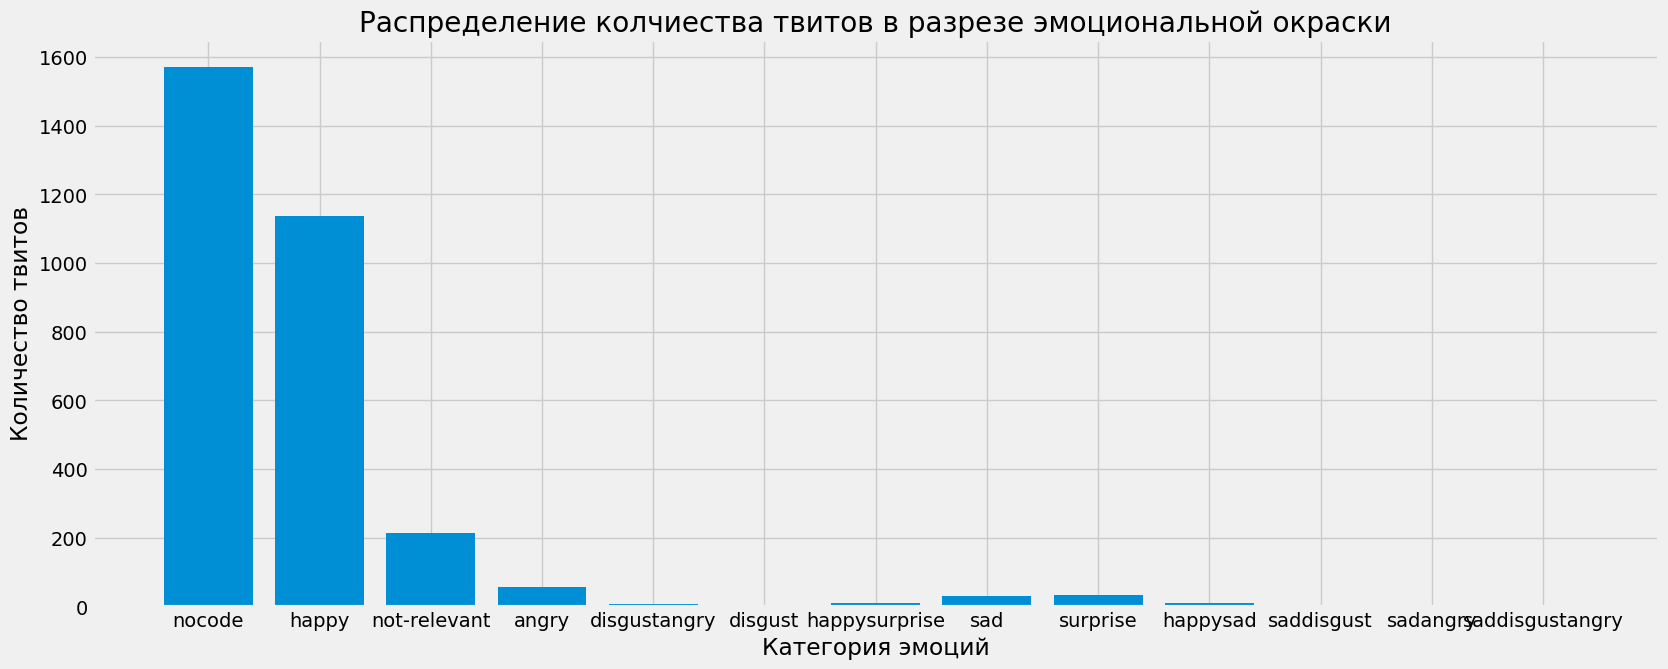

In [ ]:
# Визуализируем результат
plt.figure(figsize = (18,7))
plt.bar(df_emotions.emotions, df_emotions.counter)
plt.title("Распределение колчиества твитов в разрезе эмоциональной окраски")
plt.xlabel("Категория эмоций")
plt.ylabel("Количество твитов")
plt.savefig('category.png')

In [ ]:
dict_emotions

Counter({'nocode': 1572,
         'happy': 1137,
         'not-relevant': 214,
         'angry': 57,
         'disgustangry': 7,
         'disgust': 6,
         'happysurprise': 11,
         'sad': 32,
         'surprise': 35,
         'happysad': 9,
         'saddisgust': 2,
         'sadangry': 2,
         'saddisgustangry': 1})

Как видно, примеры некототорых эмоции, составляют очень маленькое значение и будут мешать при дальнейшем обучении модели, следовательно считаю что данные группы необходимо укрупнить и включить в группы со схожей эмоциональной окраской, кроме того считаю необходимым удалить категорию эмоций 'happysad'

In [ ]:
# Удалим категорию 'happysad'
twits = twits.loc[twits['emotions'] != 'happysad']

In [ ]:
# Cоставим словарь для укрупнения категорий эмоций
emojis_category_new ={
         'nocode': 'nocode',
         'happy': 'happy',
         'not-relevant': 'not-relevant',
         'angry': 'angry',
         'disgustangry': 'angry',
         'disgust': 'angry',
         'happysurprise': 'happy',
         'sad': 'sad',
         'surprise': 'happy',
         'saddisgust': 'sad',
         'sadangry': 'sad',
         'saddisgustangry': 'sad'
}

In [ ]:
# Прибавим данные категории
twits['emoji_new'] = twits.emotions.map(lambda x: emojis_category_new[x])
twits.sample(10)

,text,emotions,emoji_new
2763,@NationalGallery Haha There were definitely no giant eagles hanging around when we last visited !,surprise,happy
162,"6 years ago today, the greatest museum opened: the #acropolismuseum. @britishmuseum #givethemback #elginmarbles #greece",happy,happy
735,Can't wait to see Jackson #Pollock: Blind Spots @tateliverpool w/ @sstraine. Sending all best wishes for the opening https://t.co/3J4cJY0eDP,happy,happy
2768,.@_TheWhitechapel hosts Athens Now! symposium on radical #film w/ @EastEndFilmFest 4 July http://t.co/6nIWyRzuPn http://t.co/kg949thJdO,nocode,nocode
961,I'm introducing @britishmuseum Director Neil MacGregor-Germany:Memories of a Nation at #cheltlitfest tomorrow http://t.co/JoyLMUh2Tm Come!,happy,happy
789,Blog post: #AsktheGallery how not to engage with an angry audience. @NationalGallery brushes questions aside http://t.co/kfTCCyxFAD,angry,angry
2244,Happy Birthday #Rubens - #Samson and Delilah @NationalGallery - sexiest painting in the world! That #purple drapery! http://t.co/m5xvIkZEdy,happy,happy
1912,2 very special places: we loved going to the @HornimanMuseum when I was training in London; and now we're regular visitors to the @RAMMuseum,happy,happy
2982,@CSFineArtist @steven_heaton @tateliverpool Lucky you. I want to see this..,happy,happy
2267,@nautilusnat @CamUnivMuseums @ZoologyMuseum Hello and thank you for the warm welcome!,happy,happy


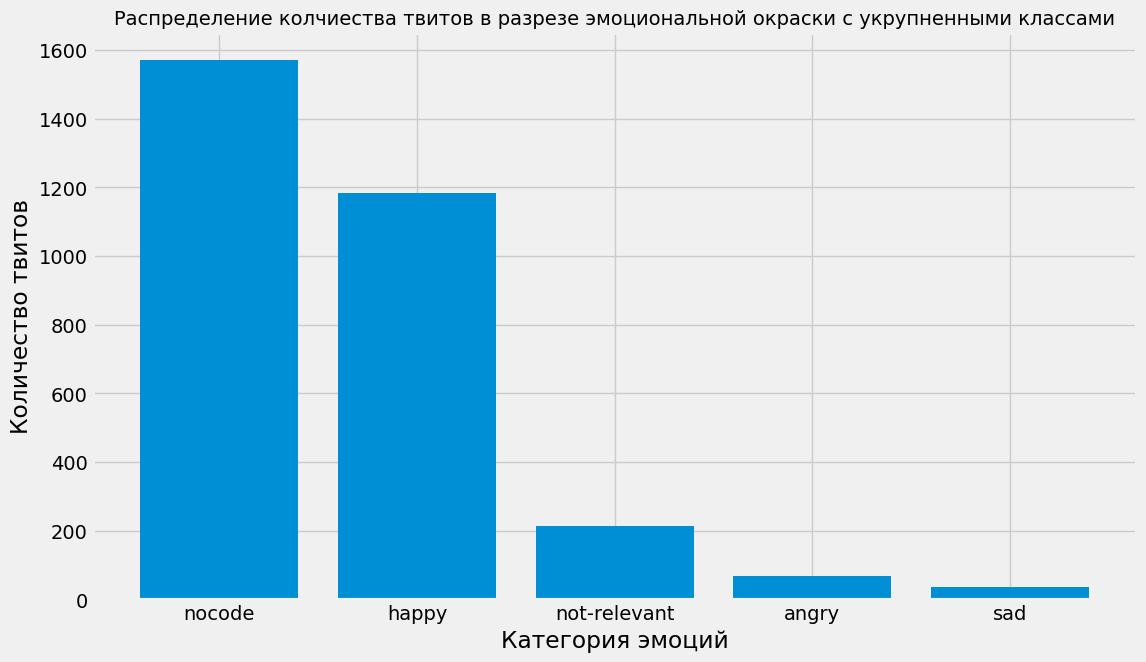

In [ ]:

dict_count = Counter(twits.emoji_new.values)
dict_count
df_emotions_new = pd.DataFrame(list(dict_count.items()), columns= ['emotions', 'counter'])
plt.figure(figsize = (12,7))
plt.bar(df_emotions_new.emotions, df_emotions_new.counter)
plt.title("Распределение колчиества твитов в разрезе эмоциональной окраски c укрупненными классами", fontsize= 14)
plt.xlabel("Категория эмоций")
plt.ylabel("Количество твитов")
plt.savefig('category_new.png')


In [ ]:
# Переводим все целевые значения в числовой формат
dict_num_form = {}
for i, j  in enumerate(dict_count.keys()):
  dict_num_form [j] = i

twits['emoji'] = twits.emoji_new.map(lambda x: dict_num_form[x])

twits.sample(10)

,text,emotions,emoji_new,emoji
2125,Etching glasses for Thursday nights Gin Performance @SeanKellyNY -6-8pm @tignortronics @MattsGallery @_TheWhitechapel http://t.co/DMa9GXyYtz,nocode,nocode,0
2310,$27M Moscow modern art gallery opens http://t.co/UcsvigSbny #RussiaMuseum @JimWard6 @britishmuseum @MuseumModernArt @Tate @artdaily,nocode,nocode,0
389,#ChristopherWilliams The Production Line of Happiness @_TheWhitechapel on until Sunday. Dynamic &amp; refreshing http://t.co/fPla90shml,happy,happy,1
130,Patients of Sharp Ward are enjoying historic views of the city thanks to @PlymouthMuseum http://t.co/TIx8wplLu9 http://t.co/x0H2a5lkHy,happy,happy,1
2809,The Top 5 Art shows 2C in London @LondonArtCritic http://t.co/xOFfTWuGqU @PianoNobile85 @_TheWhitechapel @ExploreWellcome @CGP_London,nocode,nocode,0
199,Nothing to do with football this one... its just a tiny bit exciting @tateliverpool #Pollock http://t.co/TUmZb6F7Gp,happy,happy,1
2808,Kilwa Pottery Sherds: one of the best @bbc @britishmuseum #HistoryOfTheWorldIn100Objects episodes http://t.co/Mr4EihF3dH,happy,happy,1
2620,{ @britishmuseum } #Australia #art #London #ttot #lp #vacation #trip #photography #photo #Travel #travelpics http://t.co/OvpBQoCaMP,nocode,nocode,0
1105,@ustvmad @tateliverpool @CruiseLpool @LivEchonews @scousescene fantastic!!,happy,happy,1
1846,Wow theyre #3dprinting a very ancient #museum pot for the millionth visitor @RAMMuseum #Exeter #technology #history http://t.co/G9ppdPPZrn,happy,happy,1


In [ ]:
# Разделяем данные на предикторы и целевое значение
X= twits.text.values
Y= twits.emoji.values

In [ ]:
# Разделяем данные на тренировочные и тестовые наборы данных
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=25001)

In [ ]:
# Напишем 2 функции по проведению подготовки данных для тестовой и тренировочной выборок с моделью уменьшения размерности PCA
def preprocessing_train(dataset, n_tem):
  #Очищаем данные от хэштегов и ссылок на сайты
  pattern = r'@[_a-z0-9\']+|#[_a-z0-9\']+|http.+'
  tokens = []
  for twit in dataset:
    token = [word.strip() for word in casual_tokenize(twit.lower()) if re.sub(pattern=pattern, repl='', string=word)]
    tokens.append(' '.join(token))
  # Векторизируем данные
  vectorizer =TfidfVectorizer(min_df=1)
  tfidf_vectors = vectorizer.fit_transform(tokens).toarray()
  # Нормализуем данные
  tfidf_vectors = tfidf_vectors - tfidf_vectors.mean()
  # Обучаем модель PCA и уменьшаем количество предикторов путем группировки векторов
  pca = PCA(n_components= n_tem)
  pca_vectors = pca.fit_transform(tfidf_vectors)
  return pca_vectors, vectorizer, pca

def preprocessing_test(dataset, vectorizer, pca):
  pattern = r'@[_a-z0-9\']+|#[_a-z0-9\']+|http.+'
  tokens = []
  for twit in dataset:
    token = [word.strip() for word in casual_tokenize(twit.lower()) if re.sub(pattern=pattern, repl='', string=word)]
    tokens.append(' '.join(token))
  tfidf_vectors = vectorizer.transform(tokens).toarray()
  tfidf_vectors = tfidf_vectors - tfidf_vectors.mean()
  pca_vectors = pca.transform(tfidf_vectors)
  return pca_vectors


In [ ]:
# Подбираем модель(Random_forest или SVC) с наилучшими параметрами, а также оптимальное количество предикторов
params_model =[{'n_estimators': [20, 50, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [10, 20, 40], 'min_samples_split':[3, 4, 5]}, {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}]
# Создаем переменные куда будем записывать метрики моделей
result_svm, result_tree = [], []
# Переменная в которой содержится количество тем для pca
count_tems =  [8,16, 32, 60, 70, 80, 90, 100, 120, 130, 140, 150]
# Подбор наилучшей модели
for n_tem in count_tems:
  best_model_svm, best_model_tree = [n_tem], [n_tem]
  train_data, vectorizer, pca = preprocessing_train(x_train, n_tem)
  test_data = preprocessing_test(x_test, vectorizer, pca)
  grid_svc = GridSearchCV(SVC(decision_function_shape = "ovr"), param_grid=params_model[1], refit=True, verbose= 0)
  grid_svc.fit(train_data, y_train)
  best_model_svm.append(', '.join([f'{key}: {str(value)}' for key, value in grid_svc.best_params_.items()]))
  model_svc = SVC(**grid_svc.best_params_)
  model_svc.fit(train_data, y_train)
  predict_svc = model_svc.predict(test_data)
  best_model_svm.append(round(precision_score(y_test, predict_svc, average='macro')*100, 2))
  best_model_svm.append(round(recall_score(y_test, predict_svc, average='macro')*100, 2))
  best_model_svm.append(round(model_svc.score(test_data, y_test) * 100, 2))
  best_model_svm.append(round(f1_score(y_test, predict_svc, average='macro')*100, 2))
  grid_tree = GridSearchCV(RandomForestClassifier(), param_grid=params_model[0], refit=True, verbose= 0)
  grid_tree.fit(train_data, y_train)
  best_model_tree.append(', '.join([f'{key}: {str(value)}' for key, value in grid_tree.best_params_.items()]))
  model_tree = RandomForestClassifier(**grid_tree.best_params_)
  model_tree.fit(train_data, y_train)
  predict_tree = model_tree.predict(test_data)
  best_model_tree.append(round(precision_score(y_test, predict_tree, average='macro') * 100, 2))
  best_model_tree.append(round(recall_score(y_test, predict_tree, average='macro') * 100, 2))
  best_model_tree.append(round(model_tree.score(test_data, y_test) * 100, 2))
  best_model_tree.append(round(f1_score(y_test, predict_tree, average='macro')* 100, 2))
  result_svm.append(best_model_svm)
  result_tree.append(best_model_tree)

print('Подбор модели окончен!')


Подбор модели окончен!


In [ ]:
# Значение метрик качества различных моделей
res_svc = pd.DataFrame(result_svm, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
res_tree = pd.DataFrame(result_tree, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
print('Метрики модели SVC')
res_svc



Метрики модели SVC


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"C: 100, gamma: 0.1, kernel: rbf",42.20,28.41,56.66,29.48
1,16,"C: 100, gamma: 1, kernel: rbf",45.93,32.72,65.10,34.02
2,32,"C: 10, gamma: 1, kernel: rbf",47.79,34.66,69.32,35.91
3,60,"C: 10, gamma: 1, kernel: rbf",68.77,36.33,71.10,38.50
4,70,"C: 10, gamma: 1, kernel: rbf",67.04,36.54,71.59,38.60
5,80,"C: 10, gamma: 1, kernel: rbf",67.10,36.63,71.75,38.68
6,90,"C: 100, gamma: 0.1, kernel: rbf",49.46,35.91,72.24,37.20
7,100,"C: 1, gamma: 1, kernel: rbf",49.08,35.27,70.94,36.60
8,120,"C: 1, gamma: 1, kernel: rbf",49.36,35.47,71.43,36.81
9,130,"C: 1, gamma: 1, kernel: rbf",49.24,35.59,71.59,36.89


In [ ]:
print('Метрики модели RFC')
res_tree

Метрики модели RFC


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"criterion: gini, max_depth: 40, min_samples_split: 4, n_estimators: 100",60.28,33.58,60.71,36.91
1,16,"criterion: log_loss, max_depth: 10, min_samples_split: 5, n_estimators: 100",65.87,35.51,65.42,39.00
2,32,"criterion: entropy, max_depth: 20, min_samples_split: 4, n_estimators: 100",65.23,36.85,68.18,40.24
3,60,"criterion: log_loss, max_depth: 10, min_samples_split: 5, n_estimators: 100",68.71,37.97,70.94,41.48
4,70,"criterion: gini, max_depth: 20, min_samples_split: 4, n_estimators: 100",65.71,36.55,69.32,39.31
5,80,"criterion: gini, max_depth: 40, min_samples_split: 5, n_estimators: 100",65.79,37.54,69.64,40.88
6,90,"criterion: entropy, max_depth: 40, min_samples_split: 4, n_estimators: 100",66.71,38.21,71.27,41.58
7,100,"criterion: entropy, max_depth: 40, min_samples_split: 5, n_estimators: 100",64.55,38.65,70.29,42.37
8,120,"criterion: entropy, max_depth: 10, min_samples_split: 5, n_estimators: 100",69.21,38.02,71.27,41.56
9,130,"criterion: gini, max_depth: 20, min_samples_split: 5, n_estimators: 100",66.26,37.68,70.13,41.07


In [ ]:
res_svc.to_excel('evaluate_svm.xlsx')
res_tree.to_excel('eval_tree.xlsx')

In [ ]:
# Импортируем дополнительные библиотеки для построения нейроной сети
import keras
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import to_categorical

In [ ]:
# Преобразуем целевое значение в 5 мерный вектор
n_class = 5
y_train_nn, y_test_nn = to_categorical(y_train, num_classes=n_class), to_categorical(y_test, n_class)

In [ ]:
# Подбираем наилучшие параметры для нейросети
# Количество нейронов по слоям
count_nerons=[(8, 16, 16, 5), (16, 32, 32, 5), (4, 16, 16,  5), (25, 50, 25, 5), (4, 8, 13, 5), (30, 90, 30, 5)]
result_RNN =[]
# Переменная в которой содержится количество тем для pca
count_tems = [8,16, 32, 60, 70, 80, 90, 100, 120, 130, 140, 150]
# Подбор наилучших параметров модели
for n_tem in count_tems:
  train_data, vectorizer, pca = preprocessing_train(x_train, n_tem)
  test_data = preprocessing_test(x_test, vectorizer, pca)
  best_f1, best_params = 0, []
  precision, recal, score, f1 = '', '', '', ''
  for i, j, v, n in count_nerons:
    model = Sequential()
    model.add(Dense(i, input_shape=(n_tem, )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(j))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(v))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n))
    model.add(Activation('softmax'))
    model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, y_train_nn, batch_size=32, epochs= 50, verbose= 0)
    score = round(model.evaluate(test_data, y_test_nn, verbose=0)[1] * 100, 2)
    prediction =  np.argmax(model.predict(test_data, verbose=0), axis= 1)
    precision = round(precision_score(y_test, prediction, average='macro') * 100, 2)
    recal = round(recall_score(y_test, prediction, average='macro') * 100, 2)
    f1 = round(f1_score(y_test, prediction, average='macro') * 100, 2)
    if best_f1 < f1:
      best_f1 = f1
      best_params = [n_tem, f'{i}, {j}, {v}, {n}', precision, recal, score, f1]
  result_RNN.append(best_params)


res_RNN = pd.DataFrame(result_RNN, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
print('Подбор параметров модели нейронной сети закончен!')
print()
print('Метрики модели простой нейросети')
res_RNN

Подбор параметров модели нейронной сети закончен!

Метрики модели простой нейросети


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"8, 16, 16, 5",44.15,31.18,61.36,32.50
1,16,"30, 90, 30, 5",46.46,33.39,66.56,34.65
2,32,"25, 50, 25, 5",47.18,34.58,68.51,35.71
3,60,"25, 50, 25, 5",48.86,36.08,72.08,37.25
4,70,"25, 50, 25, 5",45.16,36.05,70.29,37.37
5,80,"30, 90, 30, 5",42.22,36.75,71.27,37.75
6,90,"30, 90, 30, 5",64.21,38.64,70.94,41.45
7,100,"16, 32, 32, 5",41.51,37.06,71.59,37.88
8,120,"30, 90, 30, 5",59.93,41.71,71.10,45.33
9,130,"30, 90, 30, 5",61.83,40.33,71.92,43.84


In [ ]:
res_RNN.to_excel('evaluate_RNN.xlsx')

Вывод:
Исходя из полученных данных, можно сделать вывод, что модель "случайного леса" наиболее подходящее для эмоциональной классификации твитов по сравнению с моделью опорных векторов и простой нейронной сетью.
Попробуем увеличить точность моделей минимизируя "шум" путем удаления "стоп-слов и провоедения стеминга.

In [ ]:
# Импортируем необходимые библиотеки
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Напишем 2 функции по проведению подготовки данных для тестовой и тренировочной выборок с моделью уменьшения размерности PCA
def preprocessing_train_stem(dataset, n_tem):
  #Очищаем данные от хэштегов и ссылок на сайты
  pattern = r'@[_a-z0-9\']+|#[_a-z0-9\']+|http.+'
  tokens = []
  # Инициализируем функцию стемминга
  ss  = SnowballStemmer('english')
  for twit in dataset:
    token = [ss.stem(word) for word in casual_tokenize(twit.lower()) if re.sub(pattern=pattern, repl='', string=word)]
    token =[word for word in token if word not in stops]
    tokens.append(' '.join(token))
  # Векторизируем данные
  vectorizer =TfidfVectorizer(min_df=1)
  tfidf_vectors = vectorizer.fit_transform(tokens).toarray()
  # Нормализуем данные
  tfidf_vectors = tfidf_vectors - tfidf_vectors.mean()
  # Обучаем модель PCA и уменьшаем количество предикторов путем группировки векторов
  pca = PCA(n_components= n_tem)
  pca_vectors = pca.fit_transform(tfidf_vectors)
  return pca_vectors, vectorizer, pca

def preprocessing_test_stem(dataset, vectorizer, pca):
  pattern = r'@[_a-z0-9\']+|#[_a-z0-9\']+|http.+'
  tokens = []
  ss = SnowballStemmer('english')
  for twit in dataset:
    token = [ss.stem(word) for word in casual_tokenize(twit.lower()) if re.sub(pattern=pattern, repl='', string=word)]
    token =[word for word in token if word not in stops]
    tokens.append(' '.join(token))
  tfidf_vectors = vectorizer.transform(tokens).toarray()
  tfidf_vectors = tfidf_vectors - tfidf_vectors.mean()
  pca_vectors = pca.transform(tfidf_vectors)
  return pca_vectors

In [ ]:
# Подбираем модель(Random_forest или SVC) с наилучшими параметрами, а также оптимальное количество предикторов
params_model =[{'n_estimators': [20, 50, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [10, 20, 40], 'min_samples_split':[3, 4, 5]}, {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}]
# Создаем переменные куда будем записывать метрики моделей
result_svm, result_tree = [], []
# Переменная в которой содержится количество тем для pca
count_tems =  [8,16, 32, 60, 70, 80, 90, 100, 120, 130, 140, 150]

for n_tem in count_tems:
  best_model_svm, best_model_tree = [n_tem], [n_tem]
  train_data, vectorizer, pca = preprocessing_train_stem(x_train, n_tem)
  test_data = preprocessing_test_stem(x_test, vectorizer, pca)
  grid_svc = GridSearchCV(SVC(decision_function_shape = "ovr"), param_grid=params_model[1], refit=True, verbose= 0)
  grid_svc.fit(train_data, y_train)
  best_model_svm.append(', '.join([f'{key}: {str(value)}' for key, value in grid_svc.best_params_.items()]))
  model_svc = SVC(**grid_svc.best_params_)
  model_svc.fit(train_data, y_train)
  predict_svc = model_svc.predict(test_data)
  best_model_svm.append(round(precision_score(y_test, predict_svc, average='macro')*100, 2))
  best_model_svm.append(round(recall_score(y_test, predict_svc, average='macro')*100, 2))
  best_model_svm.append(round(model_svc.score(test_data, y_test) * 100, 2))
  best_model_svm.append(round(f1_score(y_test, predict_svc, average='macro')*100, 2))
  grid_tree = GridSearchCV(RandomForestClassifier(), param_grid=params_model[0], refit=True, verbose= 0)
  grid_tree.fit(train_data, y_train)
  best_model_tree.append(', '.join([f'{key}: {str(value)}' for key, value in grid_tree.best_params_.items()]))
  model_tree = RandomForestClassifier(**grid_tree.best_params_)
  model_tree.fit(train_data, y_train)
  predict_tree = model_tree.predict(test_data)
  best_model_tree.append(round(precision_score(y_test, predict_tree, average='macro') * 100, 2))
  best_model_tree.append(round(recall_score(y_test, predict_tree, average='macro') * 100, 2))
  best_model_tree.append(round(model_tree.score(test_data, y_test) * 100, 2))
  best_model_tree.append(round(f1_score(y_test, predict_tree, average='macro')* 100, 2))
  result_svm.append(best_model_svm)
  result_tree.append(best_model_tree)

print('Подбор модели окончен!')


Подбор модели окончен!


In [ ]:
res_svc = pd.DataFrame(result_svm, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
res_tree = pd.DataFrame(result_tree, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
print('Метрики модели SVC')
res_svc

Метрики модели SVC


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"C: 100, gamma: 1, kernel: rbf",48.17,33.64,67.69,35.01
1,16,"C: 100, gamma: 1, kernel: rbf",48.44,34.68,69.64,36.01
2,32,"C: 10, gamma: 1, kernel: rbf",49.57,35.73,71.92,37.08
3,60,"C: 100, gamma: 0.1, kernel: rbf",49.47,35.72,71.92,37.03
4,70,"C: 100, gamma: 0.1, kernel: rbf",49.38,35.67,71.75,36.99
5,80,"C: 100, gamma: 0.1, kernel: rbf",49.78,36.10,72.73,37.39
6,90,"C: 100, gamma: 0.1, kernel: rbf",50.07,36.26,73.05,37.59
7,100,"C: 100, gamma: 0.1, kernel: rbf",70.01,37.29,73.38,39.48
8,120,"C: 100, gamma: 0.1, kernel: rbf",68.12,38.15,73.38,40.97
9,130,"C: 1, gamma: 1, kernel: rbf",50.61,36.16,73.05,37.56


In [ ]:
print('Метрики модели RFC')
res_tree

Метрики модели RFC


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"criterion: gini, max_depth: 20, min_samples_split: 3, n_estimators: 50",63.67,37.92,68.51,41.63
1,16,"criterion: log_loss, max_depth: 40, min_samples_split: 4, n_estimators: 100",67.16,38.88,72.56,42.21
2,32,"criterion: gini, max_depth: 40, min_samples_split: 5, n_estimators: 50",65.36,38.85,72.24,42.04
3,60,"criterion: entropy, max_depth: 20, min_samples_split: 3, n_estimators: 100",65.09,38.37,71.43,41.61
4,70,"criterion: gini, max_depth: 20, min_samples_split: 5, n_estimators: 100",65.50,39.67,72.40,43.36
5,80,"criterion: entropy, max_depth: 20, min_samples_split: 4, n_estimators: 100",63.69,38.51,71.59,41.59
6,90,"criterion: entropy, max_depth: 10, min_samples_split: 3, n_estimators: 100",66.08,39.97,73.21,43.72
7,100,"criterion: entropy, max_depth: 20, min_samples_split: 4, n_estimators: 100",64.22,39.86,72.73,43.42
8,120,"criterion: entropy, max_depth: 40, min_samples_split: 3, n_estimators: 100",64.05,39.65,72.24,43.22
9,130,"criterion: log_loss, max_depth: 10, min_samples_split: 4, n_estimators: 100",69.13,39.58,72.40,43.51


In [ ]:
res_svc.to_excel('evaluate_svm_v2.xlsx')
res_tree.to_excel('eval_tree_v2.xlsx')

In [ ]:
# Подбираем наилучшие параметры для нейросети
# Количество нейронов по слоям
count_nerons=[(8, 16, 16, 5), (16, 32, 32, 5), (4, 16, 16,  5), (25, 50, 25, 5), (4, 8, 13, 5), (30, 90, 30, 5)]
result_RNN =[]
# Переменная в которой содержится количество тем для pca
count_tems = [8,16, 32, 60, 70, 80, 90, 100, 120, 130, 140, 150]
# Подбор наилучших параметров модели
for n_tem in count_tems:
  train_data, vectorizer, pca = preprocessing_train_stem(x_train, n_tem)
  test_data = preprocessing_test_stem(x_test, vectorizer, pca)
  best_f1, best_params = 0, []
  precision, recal, score, f1 = '', '', '', ''
  for i, j, v, n in count_nerons:
    model = Sequential()
    model.add(Dense(i, input_shape=(n_tem, )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(j))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(v))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n))
    model.add(Activation('softmax'))
    model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, y_train_nn, batch_size=32, epochs= 50, verbose= 0)
    score = round(model.evaluate(test_data, y_test_nn, verbose=0)[1] * 100, 2)
    prediction =  np.argmax(model.predict(test_data, verbose=0), axis= 1)
    precision = round(precision_score(y_test, prediction, average='macro') * 100, 2)
    recal = round(recall_score(y_test, prediction, average='macro') * 100, 2)
    f1 = round(f1_score(y_test, prediction, average='macro') * 100, 2)
    if best_f1 < f1:
      best_f1 = f1
      best_params = [n_tem, f'{i}, {j}, {v}, {n}', precision, recal, score, f1]
  result_RNN.append(best_params)


res_RNN = pd.DataFrame(result_RNN, columns =['Количество тем', 'Параметры лучшей модели', 'Точность в разрезе категорий', 'Полнота', 'Общая точность', 'f1'])
print('Подбор параметров модели нейронной сети закончен!')
print()
print('Метрики модели простой нейросети')
res_RNN

Подбор параметров модели нейронной сети закончен!

Метрики модели простой нейросети


,Количество тем,Параметры лучшей модели,Точность в разрезе категорий,Полнота,Общая точность,f1
0,8,"30, 90, 30, 5",44.68,35.06,69.32,36.30
1,16,"30, 90, 30, 5",46.63,35.97,71.10,37.22
2,32,"25, 50, 25, 5",49.15,36.73,72.73,38.09
3,60,"25, 50, 25, 5",46.82,37.43,74.35,38.59
4,70,"30, 90, 30, 5",47.18,37.70,74.19,39.05
5,80,"30, 90, 30, 5",63.05,37.62,72.89,39.41
6,90,"30, 90, 30, 5",45.29,37.35,73.21,38.53
7,100,"30, 90, 30, 5",61.43,40.41,73.86,43.21
8,120,"25, 50, 25, 5",60.20,42.85,74.68,46.57
9,130,"25, 50, 25, 5",56.04,43.32,74.84,46.46


In [ ]:
res_RNN.to_excel('evaluate_RNN_v2.xlsx')

# В результате анализа метрик качесства, лучший результат показала модель нейронной сети с 2 скрытыми слоями и количеством нейронов равным 25, 50, 25, 5, обученная на векторах твит-сообщений из которых предварительно были удалены стоп-слова и проведен стемминг данных.

In [ ]:
# Проводим обучение на полном датасете
# Создаем и инициализируем модель с лучшими параметрами  и количеством тем равным 140
model_fin = Sequential()
model_fin.add(Dense(25, input_shape=(140, )))
model_fin.add(Activation('relu'))
model_fin.add(Dropout(0.2))
model_fin.add(Dense(50))
model_fin.add(Activation('relu'))
model_fin.add(Dropout(0.2))
model_fin.add(Dense(25))
model_fin.add(Activation('relu'))
model_fin.add(Dropout(0.2))
model_fin.add(Dense(5))
model_fin.add(Activation('softmax'))
model_fin.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Проводим препроцессинг данных с помощью функции preprocessing_train_stem
x_data, vectorizer, pca = preprocessing_train_stem(X, 140)
Y_data =to_categorical(Y, 5)

In [ ]:
# Обучаем и сохраняем обученную модель
model_fin.fit(x_data, Y_data, batch_size=32, epochs= 60, verbose= 1)

Epoch 1/60
97/97 [==============================] - 1s 8ms/step - loss: 0.4395 - accuracy: 0.8397
Epoch 2/60
97/97 [==============================] - 1s 7ms/step - loss: 0.4367 - accuracy: 0.8466
Epoch 3/60
97/97 [==============================] - 1s 7ms/step - loss: 0.4387 - accuracy: 0.8462
Epoch 4/60
97/97 [==============================] - 1s 7ms/step - loss: 0.4351 - accuracy: 0.8420
Epoch 5/60
97/97 [==============================] - 1s 6ms/step - loss: 0.4395 - accuracy: 0.8430
Epoch 6/60
97/97 [==============================] - 1s 6ms/step - loss: 0.4402 - accuracy: 0.8475
Epoch 7/60
97/97 [==============================] - 0s 4ms/step - loss: 0.4410 - accuracy: 0.8404
Epoch 8/60
97/97 [==============================] - 0s 4ms/step - loss: 0.4377 - accuracy: 0.8430
Epoch 9/60
97/97 [==============================] - 0s 4ms/step - loss: 0.4361 - accuracy: 0.8407
Epoch 10/60
97/97 [==============================] - 0s 4ms/step - loss: 0.4201 - accuracy: 0.8482
Epoch 11/60
97/97 [

In [ ]:
import h5py
# Сохраняем структурук модели
model_structure = model_fin.to_json()
with open('best_model_RNN.json', 'w') as json_file:
  json_file.write(model_structure)
# Сохраняем веса
model_fin.save_weights('best_model_RNN_weight.h5')

In [ ]:
# Сохраняем словарь TFIDF
import pickle
pickle.dump(vectorizer, open('tfidf_voc.pkl', 'wb'))

In [ ]:
pickle.dump(pca, open('pca.pkl', 'wb'))

In [ ]:
test = twits.sample(10)
test= test.text
test.to_excel('test_twits.xlsx', index=False)

#Для запуска модели необходимо в корень проекта загрузить:
- структуру модели(файл best_model_RNN.json);
- веса предобученной модели(best_model_RNN_weight.h5
- Словарь tfidf(tfidf_voc.pkl)
- Предобученная модель pca (pca.pkl)

и последовательно выполнить нижепредставленные строки
```



In [ ]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import pickle as pk
import nltk
from nltk.tokenize import casual_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import keras
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from keras.src.saving.legacy.model_config import model_from_json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Входной датасет должен содержать одно поле текст твита
input_file  = 'test_twits.xlsx'
output_file = 'result.xlsx'


In [ ]:

# Создаем функцию конвейр для предсказания класса
def predict_emotions(df):
  #Загружаем предобученную модель pca и словарь для векторайзера
  pca= pk.load(open('pca.pkl', 'rb'))
  tfidf_vectors =pk.load(open('tfidf_voc.pkl', 'rb'))
  json_file = open('best_model_RNN.json', 'r')
  #Загружаем модель
  loaded_model = json_file.read()
  json_file.close
  best_model = model_from_json(loaded_model)
  # Загружаем веса
  best_model.load_weights('best_model_RNN_weight.h5')
  best_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

  #Предобработка данных  и векторизация
  pattern = r'@[_a-z0-9\']+|#[_a-z0-9\']+|http.+'
  tokens = []
  # Загружаем стемминг данных
  ss = SnowballStemmer('english')
  # Преобразуем датафрейм в массив numpy
  df1 = df.text.values
  for twit in df1:
    # Удаляем ссылки и хэштеги и делаем стемминг данных
    token = [ss.stem(word) for word in casual_tokenize(twit.lower()) if re.sub(pattern=pattern, repl='', string=word)]
    # Удаляем стоп слова
    token =[word for word in token if word not in stops]
    tokens.append(' '.join(token))
  # Проводим векторизацию данных
  vector = tfidf_vectors.transform(tokens).toarray()
  vector = vector - vector.mean()
  # Проводим уменьшение размерности данных
  pca_vectors = pca.transform(vector)
  # Предсказание
  predict = np.argmax(best_model.predict(pca_vectors, verbose= 0), axis=1)
  df_res = df
  df_res['predict'] = predict.tolist()
  return df_res





In [ ]:
df = pd.read_excel(input_file)
res = predict_emotions(df)
res
res.to_excel(output_file, index=False)